Data loaded successfully with 5735 entries.

Confidence Level: 95.0%
Male:
  Height: Mean = 173.13, CI = (172.84, 173.43)
  Weight: Mean = 86.56, CI = (85.77, 87.35)
Female:
  Height: Mean = 159.68, CI = (159.42, 159.94)
  Weight: Mean = 76.52, CI = (75.75, 77.29)
All:
  Height: Mean = 166.14, CI = (165.87, 166.40)
  Weight: Mean = 81.34, CI = (80.77, 81.91)

Confidence Level: 99.0%
Male:
  Height: Mean = 173.13, CI = (172.74, 173.52)
  Weight: Mean = 86.56, CI = (85.52, 87.60)
Female:
  Height: Mean = 159.68, CI = (159.34, 160.02)
  Weight: Mean = 76.52, CI = (75.51, 77.53)
All:
  Height: Mean = 166.14, CI = (165.79, 166.48)
  Weight: Mean = 81.34, CI = (80.59, 82.08)


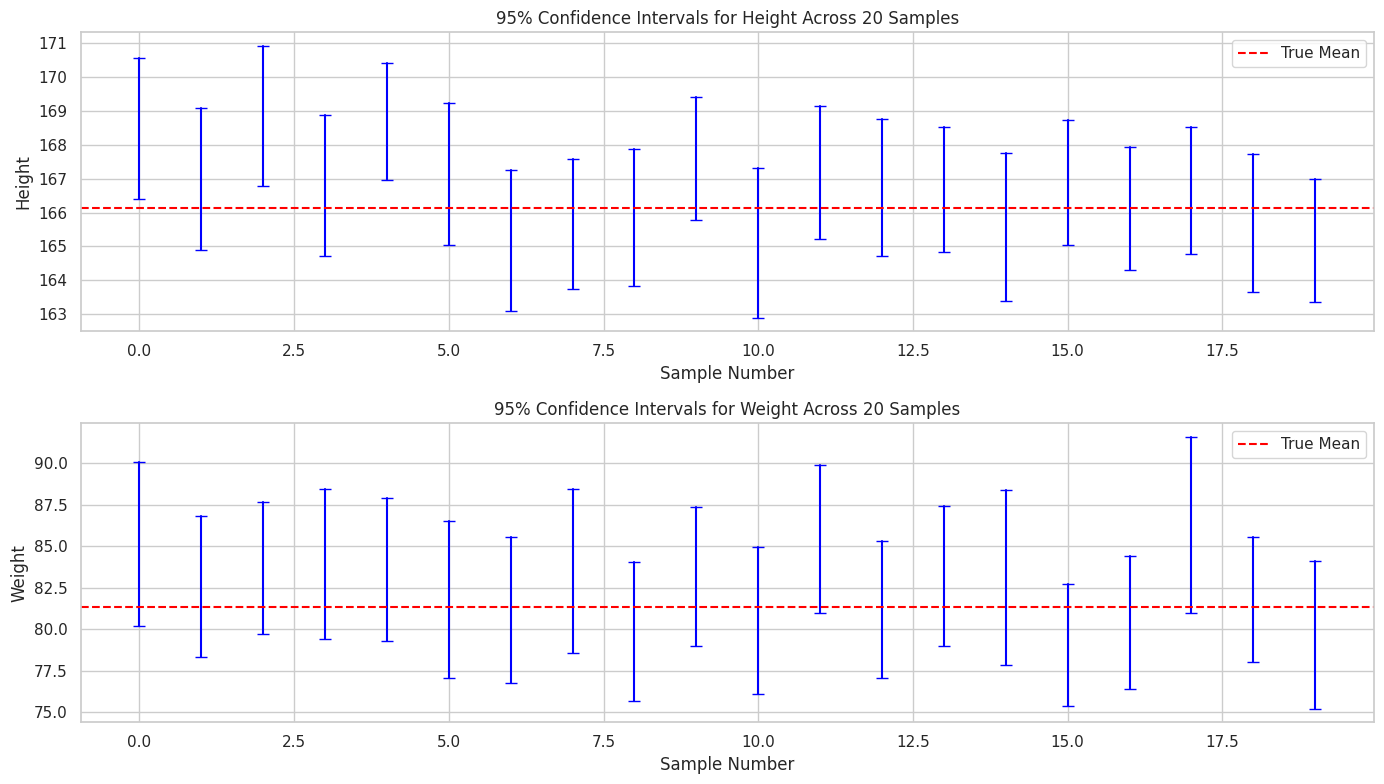

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for seaborn
sns.set(style="whitegrid")

# Loading the dataset from the manually uploaded file
def load_data(file_path):
    try:
        # Loading CSV file from file path, selecting only the columns for height (BMXHT), weight (BMXWT), and gender (RIAGENDR)
        data = pd.read_csv(file_path, usecols=['BMXHT', 'BMXWT', 'RIAGENDR'])
        print(f"Data loaded successfully with {data.shape[0]} entries.")
        return data
    except FileNotFoundError:
        raise FileNotFoundError(f"Error: The file at '{file_path}' was not found.")
    except pd.errors.EmptyDataError:
        raise ValueError("Error: The file is empty.")
    except ValueError as e:
        raise ValueError(f"Error: {e}. Please check if the specified columns exist in the CSV file.")
    except Exception as e:
        raise RuntimeError(f"An error occurred: {e}")

# The path where the file was uploaded in Google Colab.Needed to upload source excel file to files in the left side. Select the content folder and upload the file there so that the file path in the code below works.
file_path = '/content/nhanes_2015_2016.csv'

# Loading dataset and handle errors
data = load_data(file_path)

# Cleaning the dataset by removing entries with missing values
# We assume that rows with missing height or weight are not useful in the analysis.
data_cleaned = data.dropna()
#print("Cleaned Data:")
#print(data_cleaned)

# Step (b): Calculate Confidence Intervals

# Helper function to compute confidence intervals
def compute_confidence_interval(data, confidence=0.95):
    n = len(data) # Sample size
    mean = np.mean(data) # Sample mean
    sem = np.std(data, ddof=1) / np.sqrt(n)  # Standard Error of the Mean
    h = sem * t.ppf((1 + confidence) / 2., n - 1)  # Margin of error using t-distribution
    return mean, mean - h, mean + h

# Initialize a dictionary to store the results
ci_results = {}

# Confidence levels to calculate
ci_levels = [0.95, 0.99]

# Computing confidence intervals for height and weight by gender and for the entire sample
for confidence in ci_levels:
    ci_results[confidence] = {}

    # Calculate confidence intervals by gender
    for gender, group_data in data_cleaned.groupby('RIAGENDR'):
        gender_label = 'Male' if gender == 1 else 'Female'

        # Height Confidence Interval
        mean_ht, lower_ht, upper_ht = compute_confidence_interval(group_data['BMXHT'], confidence)
        # Weight Confidence Interval
        mean_wt, lower_wt, upper_wt = compute_confidence_interval(group_data['BMXWT'], confidence)

        # Storing results in dictionary with labels for each gender and measure
        ci_results[confidence][gender_label] = {
            'Height': (mean_ht, lower_ht, upper_ht),
            'Weight': (mean_wt, lower_wt, upper_wt)
        }

    # Calculate confidence intervals for the entire sample
    mean_ht_all, lower_ht_all, upper_ht_all = compute_confidence_interval(data_cleaned['BMXHT'], confidence)
    mean_wt_all, lower_wt_all, upper_wt_all = compute_confidence_interval(data_cleaned['BMXWT'], confidence)

    ci_results[confidence]['All'] = {
        'Height': (mean_ht_all, lower_ht_all, upper_ht_all),
        'Weight': (mean_wt_all, lower_wt_all, upper_wt_all)
    }

# Displaying confidence intervals by confidence level and group
for confidence, groups in ci_results.items():
    print(f"\nConfidence Level: {confidence*100}%")
    for group, stats in groups.items():
        print(f"{group}:")
        for measure, (mean, lower, upper) in stats.items():
            print(f"  {measure}: Mean = {mean:.2f}, CI = ({lower:.2f}, {upper:.2f})")

# Step (c): Sampling and Plotting Confidence Intervals

# Parameters for sampling
n_samples = 20 # Number of random samples
sample_size = 100 # Size of each sample
sample_intervals = {'Height': [], 'Weight': []} # Store intervals for plotting

# True population means for comparison
true_mean_ht = np.mean(data_cleaned['BMXHT'])
true_mean_wt = np.mean(data_cleaned['BMXWT'])

# Generating samples and calculate confidence intervals
for _ in range(n_samples):
    sample = data_cleaned.sample(sample_size)
    mean_ht, lower_ht, upper_ht = compute_confidence_interval(sample['BMXHT'], 0.95)
    mean_wt, lower_wt, upper_wt = compute_confidence_interval(sample['BMXWT'], 0.95)

    # Append calculated intervals to the sample_intervals dictionary
    sample_intervals['Height'].append((mean_ht, lower_ht, upper_ht))
    sample_intervals['Weight'].append((mean_wt, lower_wt, upper_wt))

# Plotting Confidence Intervals
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))

for i, measure in enumerate(['Height', 'Weight']):
    plt.subplot(2, 1, i + 1)
    intervals = sample_intervals[measure]

    # Plot each sample's confidence interval as a line with blue markers
    for j, (mean, lower, upper) in enumerate(intervals):
        plt.plot([j, j], [lower, upper], color='blue', marker='_', markersize=8)

    # Drawing the true mean line (for population) in red with a dashed style
    true_mean = true_mean_ht if measure == 'Height' else true_mean_wt
    plt.axhline(y=true_mean, color='red', linestyle='--', label='True Mean')

    # Labeling
    plt.title(f"95% Confidence Intervals for {measure} Across 20 Samples")
    plt.xlabel("Sample Number")
    plt.ylabel(measure)
    plt.legend()

plt.tight_layout()
plt.show()

# Observations
# At a 99% confidence level, the intervals for height and weight are wider than at 95%, which is expected.. This increase in width ensures a higher probability of capturing the true mean within the interval.
# Gender Differences:
# Males have a significantly higher mean height (173.13 cm) than females (159.68 cm). The narrow intervals for both genders indicate consistent measurements with low variability.
# Males also weigh more on average (86.56 kg) compared to females (76.52 kg). Slightly wider intervals for weight suggest more variability than seen in height.
# Population Means:
# The population mean (166.14 cm) falls between male and female averages, with stable intervals that reinforce the sampling's accuracy.
# Similarly, the population mean weight (81.34 kg) is balanced between male and female values, with slightly wider intervals reflecting higher natural variability in weight.
